In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle
import pandas as pd 

import MuC.MuC as MuC
from MuC import const
from MuC import collider_tools as col
from MuC import detector_tools as det
from MuC import plot_tools as pt

from MuC.MuC import BINSimulator
from DarkNews import Cfourvec as Cfv

## Generate some benchmark cases

In [7]:
NEVENTS = 1e6

col_designs = [col.muc_10tev, col.muc_3tev, col.mut_2tev]
col_sims = []
for design in col_designs:
    if design == col.muc_10tev:
        sim = MuC.BINSimulator(design=design, N_evals = NEVENTS, save_mem=False, remove_ring_fraction=0.9, lattice='beam-optics/ring_v06_smoothed.pkl')
    elif design == col.muc_3tev or design == col.mut_2tev:
        sim = MuC.BINSimulator(design=design, N_evals = NEVENTS, save_mem=False, remove_ring_fraction=0.9, lattice='beam-optics/ring_3tev_v1.2_smoothed.pkl')
    else:
        sim = MuC.BINSimulator(design=design, N_evals = NEVENTS, save_mem=False, remove_ring_fraction=0.9, lattice=None)
    col_sims.append(sim.run())

Efficiency of detector acceptance: 2.19e-01
Efficiency of detector acceptance: 2.20e-01
Efficiency of detector acceptance: 2.20e-01
Efficiency of detector acceptance: 2.20e-01
Total count: 1.84e+11 events;

Efficiency of detector acceptance: 4.01e-01
Efficiency of detector acceptance: 4.05e-01
Efficiency of detector acceptance: 4.01e-01
Efficiency of detector acceptance: 4.05e-01
Total count: 2.49e+10 events;

Efficiency of detector acceptance: 3.84e-01
Efficiency of detector acceptance: 3.90e-01
Efficiency of detector acceptance: 3.83e-01
Efficiency of detector acceptance: 3.89e-01
Total count: 2.06e+11 events;



#### Save this event generation if desired

In [5]:
version = 'MH_Dec11'
for design, sim in zip(col_designs, col_sims):
    with open(f'gen_data/{version}_{design["short_name"]}.pkl', 'wb') as f:
        pickle.dump(sim, f)

## Timing plots

/opt/homebrew/Caskroom/miniforge/base/envs/darknews/lib/python3.11/site-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


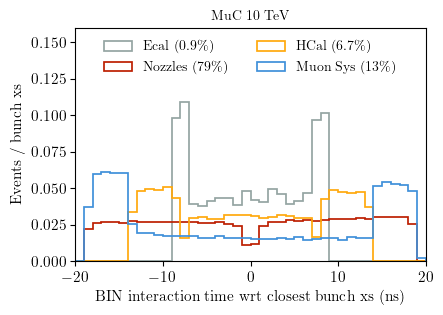

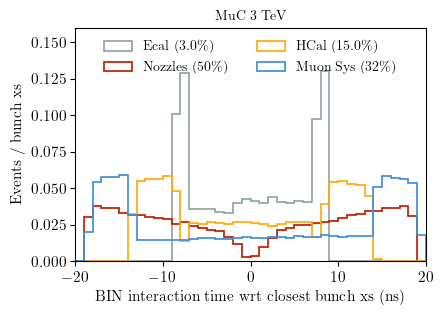

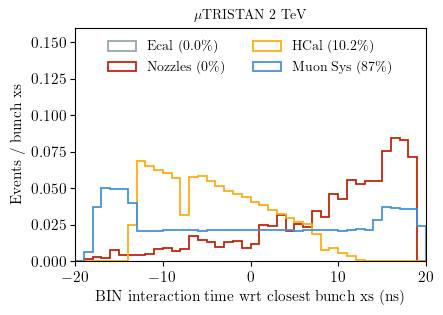

In [6]:
for sim in col_sims:
    _, _, _, wms, timesms, _, _ = sim.get_data(sec = 'muon_detector')
    _, _, _, wno, timesno, _, _ = sim.get_data(sec = 'nozzles')
    _, _, _, whc, timeshc, _, _ = sim.get_data(sec = 'hcal')
    _, _, _, wec, timesec, _, _ = sim.get_data(sec = 'ecal')
    _, _, _, wsol, timesec_sol, _, _ = sim.get_data(sec = 'solenoid_borders')

    wtot = (wms.sum() + wno.sum() + whc.sum() + wec.sum() + wsol.sum())

    fig, ax = pt.std_fig()

    bucket_time = 20 # ns
    units=1e9 # ns
    bins = np.linspace(-bucket_time, bucket_time, 2*bucket_time+1, endpoint=True)
    data = [timesms, timeshc, timesno, timesec, timesec_sol]
    data = [d*units for d in data]
    weights = [wms/sim.bunchx_in_a_year, whc/sim.bunchx_in_a_year, wno/sim.bunchx_in_a_year, wec/sim.bunchx_in_a_year, wsol/sim.bunchx_in_a_year]
    colors = [c for c in pt.cblind_safe_wheel][:5]
    labels = [fr'Muon Sys ({100*wms.sum()/wtot:.0f}\%)', fr'HCal ({100*whc.sum()/wtot:.1f}\%)', fr'Nozzles ({100*wno.sum()/wtot:.0f}\%)', fr'Ecal ({100*wec.sum()/wtot:.1f}\%)', fr'Solenoid ({100*wsol.sum()/wtot:.1f}\%)' ]

    ax.hist(data[:-1], weights = weights[:-1], bins = bins, histtype = 'step', color = colors[:-1], label = labels[:-1], stacked = False, alpha=1, lw=1.25, density=True)
    # ax.hist(data[:-1], weights = weights[:-1], bins = 100, histtype = 'step', color = colors[:-1], label = labels[:-1], stacked = False, alpha=1, lw=1.25, density=False)
    # for data, weights, colors, labels in zip(data, weights, colors, labels):
        # ax.hist(data, weights = weights, bins = bins, histtype = 'stepfilled', edgecolor = 'black', facecolor = colors, label = labels, stacked=True, alpha=1, lw=0.5)
        # ax.hist(data, weights = weights, bins = bins, histtype = 'step', edgecolor = 'black', color = colors, stacked = True, alpha=1, lw=0.75)

    ax.legend(loc = 'upper center', ncol=2, fontsize=10, frameon=False)
    ax.set_ylabel(r'Events / bunch xs')
    ax.set_xlabel('BIN interaction time wrt closest bunch xs (ns)')
    # ax.set_ylim(0 ,0.001)
    ax.set_ylim(0,0.16)
    ax.set_xlim(bins.min(), bins.max())
    # ax.set_yscale('log')
    ax.set_title(sim.design["name"], fontsize=10)
    fig.savefig(f'plots/BIN_distributions/nu_times_{sim.design["short_name"]}.pdf', bbox_inches = 'tight', dpi = 500)

## Correlations between radius and time

IndexError: boolean index did not match indexed array along axis 0; size of axis is 514392 but size of corresponding boolean axis is 205675

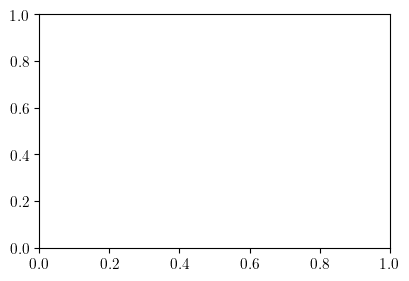

In [ ]:
for sim in col_sims:
    # x, y, z, w, times, Enu, costheta = sim.get_data(sec = 'hcal')
    x, y, z = sim.sims[0].intersection_points[:,0,0], sim.sims[0].intersection_points[:,0,1], sim.sims[0].intersection_points[:,0,2]
    w = sim.sims[0].w
    times = sim.sims[0].times

    fig, ax = pt.std_fig()
    LS = (1,(3,0.5))
    LW = 1.5

    r_bins = np.linspace(0,4e2,100)
    theta_bins = np.linspace(0,10,100)
    time_bins = np.linspace(-20,20,41)
    yunits=1e9
    xunits = 1

    kwargs = {'histtype': 'step', 'lw': LW, 'bins': bins, 'cumulative': False, 'density': True}

    r = np.sqrt(x**2 + y**2)
    mask1 = np.abs(z) < 600
    ax.hist2d(r[mask1], times[mask1]*1e9, weights = w[mask1]/1e10, bins=[r_bins, time_bins], cmin=1e-20, cmap='Blues')


    ax.set_ylabel(r'BIN interaction time wrt bunch xs')
    ax.set_xlabel(r'BIN interaction radius (cm)')

    # Loop over axes and annotate
    ax.set_title(sim.design['name'], fontsize=10)

    ax.set_xlim(r_bins.min(), r_bins.max()) 
    # ax.set_ylim(theta_bins.min(), theta_bins.max()) 
    ax.set_ylim(time_bins.min(), time_bins.max()) 

    # Adjust labels and layout
    fig.savefig('plots/BIN_distributions/radius_v_angle.pdf', bbox_inches = 'tight', dpi = 500)

## Plot lattices and event locations

In [224]:
df_10tev = pd.read_pickle('beam-optics/ring_v06_df.pkl')
df_3tev = pd.read_pickle('beam-optics/ring_3tev_v1.2_df.pkl')

In [225]:
def get_gyro_radius(E, B):
    return 3.3e2 * E / B # cm (E in GeV, B in T)

def get_dtheta(s, R):
    return s/R

def propagate(x0, y0, px0, py0, dtheta, s):
    # r = np.sqrt(x0**2 + y0**2)
    theta_p = np.arctan2(py0, px0) 
    p = np.sqrt(px0**2 + py0**2)
    pxf = p * np.cos(theta_p - dtheta)
    pyf = p * np.sin(theta_p - dtheta)

    if dtheta == 0:
        return x0 + s*np.cos(theta_p), y0+s*np.sin(theta_p), pxf, pyf
    else:
        R = s/dtheta
        # coordinates centered around larmor circle
        x0_prime = R * np.cos(np.pi/2 + theta_p)
        y0_prime = R * np.sin(np.pi/2 + theta_p)

        xf_prime = R * np.cos(np.pi/2 + theta_p - dtheta)
        yf_prime = R * np.sin(np.pi/2 + theta_p - dtheta)

        dx = xf_prime - x0_prime
        dy = yf_prime - y0_prime

        
        return x0 + dx, y0 + dy, pxf, pyf
    

In [264]:
def plot_lattice(df, ax, units = 1, draw_center_line=True):
    if draw_center_line:
        ax.plot(df['x'] * units,df['y'] * units, linewidth=0.5, c='black')

    # Minimum size of linear step
    ds = 0.1  * units

    # How tall is the magnet for x-y plane
    magnet_thickness = 1  * units
    n_elements = df.index.size
    ds = 0.1 * units

    for i in list(range(n_elements-100,n_elements-8)):
        x, y, s = df['x'][i] * units, df['y'][i] * units, df['L'][i] * units
        px, py = df['px'][i], df['py'][i]
        theta_p = np.arctan2(py, px)
        dtheta = df['ANGLE'][i]
        r_arc = s/dtheta

        if df['L'][i] > 0:
            n_discrete_bend = max(int(s / ds), 30)
            x0, y0, px0, py0 = x, y, px, py
            for j in range(n_discrete_bend):
                xn, yn, pxn, pyn = propagate(x0, y0, px0, py0, dtheta/n_discrete_bend, s/n_discrete_bend)
                theta_pn = np.arctan2(pyn, pxn)

                if df['KEYWORD'][i] == 'SBEND' or df['KEYWORD'][i] == 'RBEND':
                    rect = patches.Rectangle((x0, y0-magnet_thickness*np.cos(theta_pn)/2), width=s/n_discrete_bend, height=magnet_thickness, angle=theta_pn*180/np.pi, linewidth=0.5, edgecolor=pt.cblind_safe_wheel[0], facecolor=pt.cblind_safe_wheel[0], zorder=0.5, alpha=1) 
                elif df['KEYWORD'][i] == 'QUADRUPOLE' or df['KEYWORD'][i] == 'MULTIPOLE' or df['KEYWORD'][i] == 'RCOLLIMATOR':
                    rect = patches.Rectangle((x0, y0-magnet_thickness*np.cos(theta_pn)/2), width=s/n_discrete_bend, height=magnet_thickness, angle=theta_pn*180/np.pi, linewidth=0.5, edgecolor=pt.cblind_safe_wheel[1], facecolor=pt.cblind_safe_wheel[1], zorder=0.51, alpha=1) 
                elif df['KEYWORD'][i] == 'DRIFT':
                    rect = patches.Rectangle((x0, y0-magnet_thickness*np.cos(theta_pn)/2), width=s/n_discrete_bend, height=magnet_thickness, angle=theta_pn*180/np.pi, linewidth=0.5, edgecolor='lightgrey', facecolor='lightgrey', zorder=0.5, alpha=1) 

                ax.add_patch(rect)
                x0, y0, px0, py0 = xn, yn, pxn, pyn

    return ax

/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_70733/1476606793.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  r_arc = s/dtheta
/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_70733/1476606793.py:18: RuntimeWarning: invalid value encountered in scalar divide
  r_arc = s/dtheta


vmin: 1.5740915517700258, vmax: 4905094232.168561
vmin: 50.18226844427908, vmax: 32097756.203048315


/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_70733/2754704864.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1a.set_yticklabels(ax.get_yticklabels(), fontsize=9)
/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_70733/2754704864.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)
/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_70733/2754704864.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)
/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_70733/2754704864.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fix

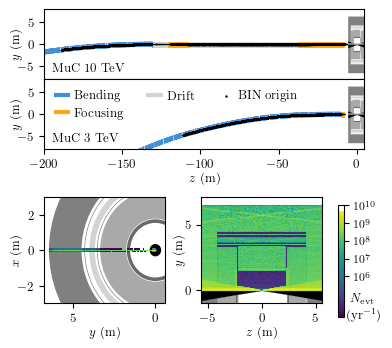

In [305]:
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

import MuC.plot_tools

# from mpl_toolkits.axes_grid1 import make_axes_locatable
# fig, axs = plt.subplots(2, 2, figsize = (4.0, 3.8))
fig = plt.figure(figsize=(4.0, 3.5))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 2], width_ratios=[1, 1])
CMAP = 'viridis'

ax1a = plt.subplot(gs[0,:])
ax1b = plt.subplot(gs[1,:])
ax2 = plt.subplot(gs[2,0])
ax3 = plt.subplot(gs[2,1])

plot_lattice(df_10tev, ax1a, units=100, draw_center_line=False)
plot_lattice(df_3tev, ax1b, units=100, draw_center_line=False)

col1 = col_sims[0]
col2 = col_sims[1]

ax1b.plot([], [], lw=3, color = pt.cblind_safe_wheel[0], label = r"Bending")
ax1b.plot([], [], lw=3, color = pt.cblind_safe_wheel[1], label = r"Focusing")
ax1b.plot([], [], lw=3, color = 'lightgrey', label = r"Drift")
# ax1b.scatter([], [], facecolor = 'black', s=5, marker='.', linewidth=1, label = r"Muon decay")

nmax=int(1e6)
ax1a.scatter((col1.sims[0]).intersection_points[:,0,2][:nmax], (col1.sims[0]).intersection_points[:,0,1][:nmax], s = 3, marker='.', linewidth=0, c = 'black', rasterized=True)
ax1b.scatter((col2.sims[0]).intersection_points[:,0,2][:nmax], (col2.sims[0]).intersection_points[:,0,1][:nmax], s = 3, marker='.',  linewidth=0, c = 'black', rasterized=True, label = r"BIN origin")

ax1b.legend(fontsize=9, loc='upper left', handlelength=1, handletextpad=0.5, markerscale=2, ncol=3)

MuC.plot_tools.plot_det('det_v2', ax = ax1a)
MuC.plot_tools.plot_det('det_v2', ax = ax1b)

for ax1 in [ax1a, ax1b]:
    ax1.set_ylim(-800, 800)
    ax1.set_xlim(-200e2, 500)

# units = 1e2 #cm
collider = col_sims[1]

hist1 = collider.plot(cmap=CMAP, orientation='y-x', fs=None, ax=ax2, colorbar=0, h=True, cmin=1, title=False, nbins=400)
hist2 = collider.plot(cmap=CMAP, orientation='z-y', fs=None, ax=ax3, colorbar=0, h=True, title=0, cmin=1, nbins=400)

ax1a.set_ylabel(r'$y$ (m)', labelpad=-3, fontsize=9)
ax1b.set_ylabel(r'$y$ (m)', labelpad=-3, fontsize=9)
ax1b.set_xlabel(r'$z$ (m)', labelpad=1, fontsize=9)

ax2.set_ylabel(r'$x$ (m)', labelpad=-3, fontsize=9)
ax2.set_xlabel(r'$y$ (m)', labelpad=1, fontsize=9)

ax3.set_ylabel(r'$y$ (m)', labelpad=-0, fontsize=9)
ax3.set_xlabel(r'$z$ (m)', labelpad=1, fontsize=9)

ax2.set_xlim(collider.rmax*1.05,-60)
ax3.set_ylim(-100,collider.rmax*1.1)
ax2.set_ylim(-300, 300)
ax3.set_xlim(-collider.zending,collider.zending)

ax1a.set_xticklabels([])
ax1a.set_yticklabels(ax.get_yticklabels(), fontsize=9)
ticks_y = ticker.FuncFormatter(lambda y, pos: r'${0:g}$'.format(y/100))
ax1a.yaxis.set_major_formatter(ticks_y)

for ax in [ax1b, ax2, ax3]:
    # ax.set_xticks(ax.get_xticks(), fontsize)
    # ax.set_yticks(ax.get_yticks(), fontsize)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=9)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)
    
    ticks_x = ticker.FuncFormatter(lambda x, pos: r'${0:g}$'.format(x/100))
    ax.xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda y, pos: r'${0:g}$'.format(y/100))
    ax.yaxis.set_major_formatter(ticks_y)    
# ax3.set_yticklabels([])

# ax2.text(-2.8e2, 5e2, r'$z=0$')
# ax3.text(-500, 500, r'$x=0$')

# Add a colorbar that spans both subplots

fig.subplots_adjust(hspace=0.4, wspace=0.3, right=0.82)
cbar_ax = fig.add_subplot(111)  # Create a new subplot for the colorbar
cbar = fig.colorbar(hist1[3], ax=[ax2, ax3], cax=cbar_ax)  # Create the colorbar
cbar_ax.set_position([0.86, 0.07, 0.015, 0.32])
cbar_ax.set_yticks([1e6, 1e7, 1e8, 1e9, 1e10])
cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), fontsize=8)
cbar_ax.text(1.4, 4e4, r'\noindent \,\,$N_{\rm evt}$\\(yr$^{-1}$)', fontsize=9)

ax1a.text(-195e2, -7e2, r'MuC 10 TeV', fontsize=9, verticalalignment='bottom', horizontalalignment='left')
ax1b.text(-195e2, -7e2, r'MuC 3 TeV', fontsize=9, verticalalignment='bottom', horizontalalignment='left')

ax1a.set_position([0.125, 0.07+0.68, 0.8, 0.2])
ax1b.set_position([0.125, 0.07+0.68-0.2, 0.8, 0.2])
fig.savefig('plots/BIN_distributions/BIN_locations.pdf', dpi = 500, bbox_inches = 'tight')

## Loading BIN GENIE simulation files

In [ ]:
test = col_sims[0]
test.load_all_GENIE_events([f'Q2_mucols2_numu.txt',f'Q2_mucols2_nue.txt'], n_events = 1e6)

Loading generated data for a IMCC-II experiment;
It includes interactions from ν_μ, anti ν_μ within the MD, SB, SM, HC, EC, NO of the muon detector.
Adding weights...
Computing Q2...
Done!
Loading generated data for a IMCC-II experiment;
It includes interactions from ν_e, anti ν_e within the MD, SB, SM, HC, EC, NO of the muon detector.
Adding weights...
Computing Q2...
Done!


In [20]:
_=plt.hist(test.genie_events['nu_E'][test.genie_nuebar], bins =100, histtype='step', label='nuebar')
_=plt.hist(test.genie_events['nu_E'][test.genie_numu], bins =100, histtype='step', label='numu')
_=plt.hist(test.genie_events['nu_E'][test.genie_nue], bins =100, histtype='step', label='nue')
_=plt.hist(test.genie_events['nu_E'][test.genie_numubar], bins =100, histtype='step', label='numubar')
plt.legend()

AttributeError: 'DetectorSimulator' object has no attribute 'genie_events'

Text(0.5, 1.0, 'Neutrino fractional energy')

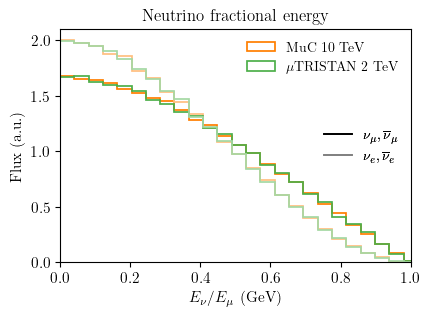

In [732]:
bins = np.linspace(0,2, 50)

light_factor = 0.5
LW=1.25

fig, ax = pt.std_fig()
def plot_curve(i):
    ax.hist(col_sims[i].mustorage_sims[1].pnu[:,0]/col_sims[i].design['beam_p0'], weights = col_sims[i].mustorage_sims[1].weights, bins = bins, histtype = 'step', label = col_sims[i].design['name'], color = pt.cblind_safe_wheel[i], zorder = 2, lw=LW, density=True)
    ax.hist(col_sims[i].mustorage_sims[0].pnu[:,0]/col_sims[i].design['beam_p0'], weights = col_sims[i].mustorage_sims[0].weights, bins = bins, histtype = 'step', color = pt.lighten_color(pt.cblind_safe_wheel[i],light_factor), zorder = 2, lw=LW, density=True)

# plot_curve(0)
plot_curve(1)
plot_curve(2)
# plot_curve(3)
# plot_curve(4)

# standard legend
leg1 = ax.legend(loc = 'upper right')

# Create a new legend
dark_line = plt.Line2D([], [], color='black', lw=LW, label=r'$\nu_\mu,\overline\nu_\mu$')
light_line = plt.Line2D([], [], color='gray', lw=LW, label=r'$\nu_e,\overline\nu_e$')
leg2 = ax.legend(handles=[dark_line, light_line], loc='center right')

plt.gca().add_artist(leg1)
plt.gca().add_artist(leg2)

ax.set_xlabel(r'$E_{\nu}/E_\mu$ (GeV)')
ax.set_ylabel(r'Flux (a.u.)')
# plt.xscale('log')
# ax.set_xlim(10,0.6*10**4)
ax.set_xlim(0,1)
ax.set_title(r'Neutrino fractional energy', fontsize = 12)
# plt.savefig('plots_Luc/posterplots/pl_e.jpg', bbox_inches = 'tight', dpi = 500)

In [733]:
def get_angle(p):
    return np.arccos(p[:,-1]/np.linalg.norm(p, axis = 1))


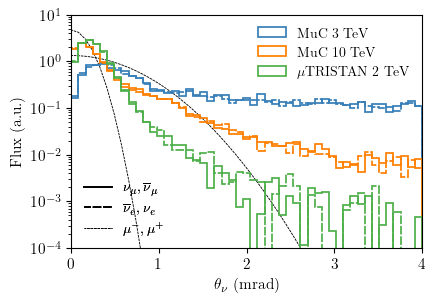

In [739]:
# bins = np.geomspace(1e-2,3, 100)
bins = np.linspace(0,4, 50)
light_factor = 1
LW=1.25
units = 1e3#180/np.pi
fig, ax = pt.std_fig()

kwargs = {'zorder': 2, 'lw': LW, 'histtype': 'step', 'bins': bins, 'cumulative': False, 'density': True}
def plot_curve(i, color=None):
    if color is None:
        color=i
    ax.hist(units*get_angle(col_sims[i].mustorage_sims[1].momenta), weights = col_sims[i].mustorage_sims[1].weights, label = col_sims[i].design['name'], color = pt.cblind_safe_wheel[color], **kwargs)
    ax.hist(units*get_angle(col_sims[i].mustorage_sims[0].momenta), weights = col_sims[i].mustorage_sims[0].weights, color = pt.lighten_color(pt.cblind_safe_wheel[color],light_factor), ls=(1,(5,1)), **kwargs)

plot_curve(0)
plot_curve(1)
plot_curve(2)
# plot_curve(3)
# plot_curve(4)

def gauss(x, mu, sigma):
    return 2/np.sqrt(2 * np.pi * sigma**2) * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

ax.plot(bins, gauss(bins, 0, 6e-4*units), color = 'black', lw = LW*0.5, ls=(1,(3,1)), zorder = 1)  #label = 'Gaussian ($\sigma = 0.60$~mrad)')
ax.plot(bins, gauss(bins, 0, 1.70e-4*units), color = 'black', lw = LW*0.5, ls=(1,(3,1)), zorder = 1)  #label = 'Gaussian ($\sigma = 0.17$~mrad)')
# standard legend
leg1 = ax.legend(loc = 'upper right')


# Create a new legend
dark_line = plt.Line2D([], [], color='black', lw=LW, label=r'$\nu_\mu,\overline\nu_\mu$')
light_line = plt.Line2D([], [], color='black', lw=LW, ls=(1,(5,1)), label=r'$\overline\nu_e,\nu_e$')
lighter_line = plt.Line2D([], [], color='black', lw=LW/2, ls=(1,(3,1)), label=r'$\mu^{-},\mu^+$')
leg2 = ax.legend(handles=[dark_line, light_line,lighter_line], loc='lower left')

plt.gca().add_artist(leg1)
plt.gca().add_artist(leg2)

ax.set_xlabel(r'$\theta_\nu$ (mrad)')
ax.set_ylabel(r'Flux (a.u.)')
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-4, 10)
ax.set_xlim(bins.min(), bins.max())
plt.savefig('plots/paper_plots/beam_size.pdf', bbox_inches = 'tight', dpi = 500)

## Polarization study

In [358]:
def get_sim_with_new_Pol(sim, P):
    return sim.reweigh_with_new_polarization(P)

Pols = np.linspace(-1, 1, 11)

In [ ]:
Counts = {}
mask = (Pols != 0)
Counts['nue_left'] = [sim.reweigh_with_new_polarization(p)['Total','nue_left'] for p in Pols[mask]]
Counts['numubar_left'] = [sim.reweigh_with_new_polarization(p)['Total','numubar_left'] for p in Pols[mask]]
Counts['nue_right'] = [sim.reweigh_with_new_polarization(p)['Total','nue_right'] for p in Pols[mask]]
Counts['numubar_right'] = [sim.reweigh_with_new_polarization(p)['Total','numubar_right'] for p in Pols[mask]]

In [371]:
Counts_10TeV = {}
mask = (Pols != 0)
Counts_10TeV['nue_left'] = [sim_10tev.reweigh_with_new_polarization(p)['Total','nue_left'] for p in Pols[mask]]
Counts_10TeV['numubar_left'] = [sim_10tev.reweigh_with_new_polarization(p)['Total','numubar_left'] for p in Pols[mask]]
Counts_10TeV['nuebar_right'] = [sim_10tev.reweigh_with_new_polarization(p)['Total','nuebar_right'] for p in Pols[mask]]
Counts_10TeV['numu_right'] = [sim_10tev.reweigh_with_new_polarization(p)['Total','numu_right'] for p in Pols[mask]]

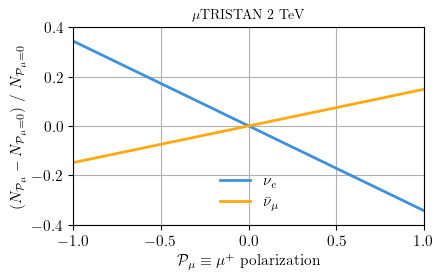

In [391]:
fig, ax = pt.std_fig(figsize=(4.44, 2.6))

# ax.plot(Pols[mask], [sim.facecounts['Total','Total']/4 for sim in Pol_sims], label=r'Total/4', color='black')
ax.plot(Pols[mask], (Counts['nue_left']/np.mean(Counts['nue_left']) - 1), label=r'$\nu_e$', color=pt.cblind_safe_wheel[0], lw=2)
# ax.plot(Pols[mask], Counts['numubar_left']/np.mean(Counts['numubar_left']) - 1, label=r'$\bar\nu_\mu$', color=pt.cblind_safe_wheel[1], ls=(1,(3,1)))
# ax.plot(Pols[mask], Counts['nue_right']/np.mean(Counts['nue_right']) - 1, label=r'$\bar\nu_e$', color=pt.cblind_safe_wheel[0], ls=(1,(3,1)))
ax.plot(Pols[mask], (Counts['numubar_right']/np.mean(Counts['numubar_right']) - 1), label=r'$\bar\nu_\mu$', color=pt.cblind_safe_wheel[1], ls='-', lw=2)

# standard legend
leg1 = ax.legend(loc = 'lower center', ncols=1, fontsize=11)

# Create a new legend
# dark_line = plt.Line2D([], [], color='black', lw=LW, label=r'Total')
# light_line = plt.Line2D([], [], color='black', lw=LW, ls=(1,(3,1)), label=r'nozzles')
# leg2 = ax.legend(handles=[dark_line, light_line], loc='upper left')

# plt.gca().add_artist(leg1)
# plt.gca().add_artist(leg2)

ax.set_ylim(-0.4,0.4)
ax.set_xlim(-1,1)
# ax.vlines(0, -1, 1, color='black', ls='-', lw=0.5)
# ax.hlines(0, -1, 1, color='black', ls='-', lw=0.5)
ax.grid()
# ax.set_yscale('log')
ax.set_title('$\mu$TRISTAN 2 TeV', fontsize=10)
ax.set_xlabel(r'$\mathcal{P}_\mu \equiv \mu^+$ polarization')
ax.set_ylabel(r'($N_{\mathcal{P}_\mu} - N_{\mathcal{P}_\mu=0}$) / $N_{\mathcal{P}_\mu=0}$')
fig.savefig('plots/BIN_distributions/mutristan_pol_sensitivity.pdf', bbox_inches = 'tight', dpi = 400)

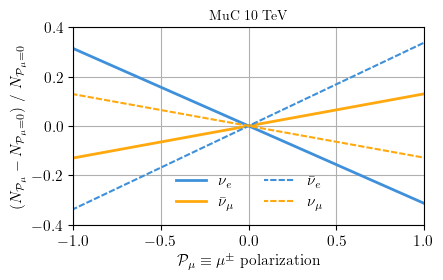

In [388]:
fig, ax = pt.std_fig(figsize=(4.44, 2.6))

# ax.plot(Pols[mask], [sim.facecounts['Total','Total']/4 for sim in Pol_sims], label=r'Total/4', color='black')
ax.plot(Pols[mask], (Counts_10TeV['nue_left']/np.mean(Counts_10TeV['nue_left']) - 1), label=r'$\nu_e$', color=pt.cblind_safe_wheel[0], lw=2)
ax.plot(Pols[mask], (Counts_10TeV['numubar_left']/np.mean(Counts_10TeV['numubar_left']) - 1), label=r'$\bar\nu_\mu$', color=pt.cblind_safe_wheel[1], ls='-', lw=2)
ax.plot(Pols[mask], (Counts_10TeV['nuebar_right']/np.mean(Counts_10TeV['nuebar_right']) - 1), label=r'$\bar\nu_e$', color=pt.cblind_safe_wheel[0], ls=(1,(3,1)))
ax.plot(Pols[mask], (Counts_10TeV['numu_right']/np.mean(Counts_10TeV['numu_right']) - 1), label=r'$\nu_\mu$', color=pt.cblind_safe_wheel[1], ls=(1,(3,1)))

# standard legend
leg1 = ax.legend(loc = 'lower center', ncols=2, fontsize=11)

# Create a new legend
# dark_line = plt.Line2D([], [], color='black', lw=LW, label=r'Total')
# light_line = plt.Line2D([], [], color='black', lw=LW, ls=(1,(3,1)), label=r'nozzles')
# leg2 = ax.legend(handles=[dark_line, light_line], loc='upper left')

# plt.gca().add_artist(leg1)
# plt.gca().add_artist(leg2)

ax.set_ylim(-0.4,0.4)
ax.set_xlim(-1,1)
# ax.vlines(0, -1, 1, color='black', ls='-', lw=0.5)
# ax.hlines(0, -1, 1, color='black', ls='-', lw=0.5)
ax.grid()
# ax.set_yscale('log')
ax.set_title('MuC 10 TeV', fontsize=10)
ax.set_xlabel(r'$\mathcal{P}_\mu \equiv \mu^\pm$ polarization')
ax.set_ylabel(r'($N_{\mathcal{P}_\mu} - N_{\mathcal{P}_\mu=0}$) / $N_{\mathcal{P}_\mu=0}$')
fig.savefig('plots/BIN_distributions/muc10tev_pol_sensitivity.pdf', bbox_inches = 'tight', dpi = 400)

/var/folders/dl/ccbsfs591r1fhgcws28m8xy40000gn/T/ipykernel_84983/175746201.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc = 'upper right')


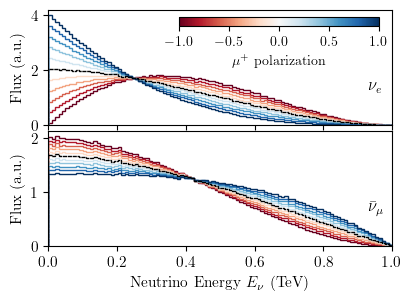

In [68]:
import matplotlib as mpl
from DarkNews import Cfourvec as Cfv

norm = mpl.colors.Normalize(vmin=Pols.min(), vmax=Pols.max())
cmap = mpl.cm.RdBu
colors = cmap(np.linspace(0, 1, len(Pols)))

# fig, ax = plt.
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=pt.std_figsize)

b = np.linspace(0, 1, 100)
for i in range(len(Pols)):
#     plt.hist(np.arccos(Cfv.get_cosTheta(Pol_sims[i].cco.pnumu)), color=colors[i], weights=Pol_sims[i].cco.weights, bins=b, histtype='step', zorder=1-i/100)
    if Pols[i] == 0:
        w = sim.mustorage_sims[1].reweigh_with_new_polarization(Pols[i])
        ax2.hist(1e-3*sim.mustorage_sims[1].pnu[:,0], weights=w/np.sum(w)*len(b), bins=b, histtype='step', color='black', ls=(1,(3,0.5)),label=r'$P = 0$', zorder=1.2)
        w = sim.mustorage_sims[0].reweigh_with_new_polarization(Pols[i])
        ax1.hist(1e-3*sim.mustorage_sims[0].pnu[:,0], weights=w/np.sum(w)*len(b), bins=b, histtype='step', color='black', ls=(1,(3,0.5)), zorder=1.2)

    else:
        w = sim.mustorage_sims[1].reweigh_with_new_polarization(Pols[i])
        ax2.hist(1e-3*sim.mustorage_sims[1].pnu[:,0], weights=w/np.sum(w)*len(b), bins=b, histtype='step', color=colors[i], zorder=1.1)
        w = sim.mustorage_sims[0].reweigh_with_new_polarization(Pols[i])
        ax1.hist(1e-3*sim.mustorage_sims[0].pnu[:,0], weights=w/np.sum(w)*len(b), bins=b, histtype='step', color=colors[i], zorder=1.1)

# plt.legend()
# fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
#              cax=ax, orientation='horizontal', label='Some Units')

ax2.set_xlim(b.min(), b.max())
ax1.set_ylabel(r'Flux (a.u.)')
ax2.set_ylabel(r'Flux (a.u.)')
ax2.set_xlabel(r'Neutrino Energy $E_{\nu}$ (TeV)')
ax1.legend(loc = 'upper right')

# cax = fig.add_axes([0.42, 0.43, 0.45, 0.03])
cax = fig.add_axes([0.42, 0.825, 0.45, 0.03])
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation="horizontal", cax=cax, ticklocation='bottom')
cbar.ax.tick_params(labelsize=10)
cbar.set_label(r'$\mu^+$ polarization', fontsize=10)  # Set the label font size
ax1.annotate(r'$\nu_e$', xy=(0.93, 0.3), xycoords='axes fraction', fontsize=12)
ax2.annotate(r'$\bar\nu_\mu$', xy=(0.93, 0.3), xycoords='axes fraction', fontsize=12)
plt.subplots_adjust(hspace=0.05)  # Change the value to adjust spacing
plt.savefig('plots/paper_plots/polarized_energy_dist.pdf', bbox_inches = 'tight', dpi = 500)

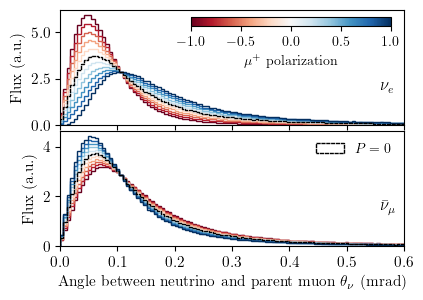

In [71]:
import matplotlib as mpl
from DarkNews import Cfourvec as Cfv

norm = mpl.colors.Normalize(vmin=Pols.min(), vmax=Pols.max())
cmap = mpl.cm.RdBu
colors = cmap(np.linspace(0, 1, len(Pols)))

# fig, ax = plt.
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=pt.std_figsize)

b = np.linspace(0, 0.6, 100)
for i in range(len(Pols)):
    if Pols[i] == 0:
        w = sim.mustorage_sims[1].reweigh_with_new_polarization(Pols[i])
        ax2.hist(1e3*np.arccos(Cfv.get_cos_opening_angle(sim.mustorage_sims[1].pnu, sim.mustorage_sims[1].pmu)), weights=w/np.sum(w)*len(b), bins=b, histtype='step', color='black', ls=(1,(3,0.5)),label=r'$P = 0$', zorder=1.2)
        w = sim.mustorage_sims[0].reweigh_with_new_polarization(Pols[i])
        ax1.hist(1e3*np.arccos(Cfv.get_cos_opening_angle(sim.mustorage_sims[0].pnu, sim.mustorage_sims[0].pmu)), weights=w/np.sum(w)*len(b), bins=b, histtype='step', color='black', ls=(1,(3,0.5)), zorder=1.2)

    else:
        w = sim.mustorage_sims[1].reweigh_with_new_polarization(Pols[i])
        ax2.hist(1e3*np.arccos(Cfv.get_cos_opening_angle(sim.mustorage_sims[1].pnu, sim.mustorage_sims[1].pmu)), weights=w/np.sum(w)*len(b), bins=b, histtype='step', color=colors[i], zorder=1.1)
        w = sim.mustorage_sims[0].reweigh_with_new_polarization(Pols[i])
        ax1.hist(1e3*np.arccos(Cfv.get_cos_opening_angle(sim.mustorage_sims[0].pnu, sim.mustorage_sims[0].pmu)), weights=w/np.sum(w)*len(b), bins=b, histtype='step', color=colors[i], zorder=1.1)

ax2.set_xlim(b.min(), b.max())
# ax1.set_yscale('log')
# ax2.set_yscale('log')
ax1.set_ylabel(r'Flux (a.u.)')
ax2.set_ylabel(r'Flux (a.u.)')
ax2.set_xlabel(r'Angle between neutrino and parent muon $\theta_{\nu}$ (mrad)')
ax2.legend(loc = 'upper right')
cax = fig.add_axes([0.42, 0.825, 0.45, 0.03])
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation="horizontal", cax=cax, ticklocation='bottom')
cbar.ax.tick_params(labelsize=10)
cbar.set_label(r'$\mu^+$ polarization', fontsize=10)  # Set the label font size
ax1.annotate(r'$\nu_e$', xy=(0.93, 0.3), xycoords='axes fraction', fontsize=12)
ax2.annotate(r'$\bar\nu_\mu$', xy=(0.93, 0.3), xycoords='axes fraction', fontsize=12)

plt.subplots_adjust(hspace=0.05)  # Change the value to adjust spacing
plt.savefig('plots/paper_plots/polarized_angle_dist.pdf', bbox_inches = 'tight', dpi = 500)

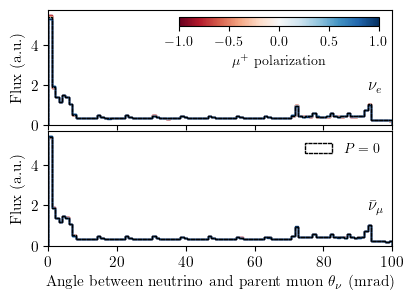

In [70]:
import matplotlib as mpl
from DarkNews import Cfourvec as Cfv

norm = mpl.colors.Normalize(vmin=Pols.min(), vmax=Pols.max())
cmap = mpl.cm.RdBu
colors = cmap(np.linspace(0, 1, len(Pols)))

# fig, ax = plt.
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=pt.std_figsize)

b = np.linspace(0, 100, 100)
for i in range(len(Pols)):
    if Pols[i] == 0:
        w = sim.mustorage_sims[1].reweigh_with_new_polarization(Pols[i])
        ax2.hist(1e3*np.arccos(Cfv.get_cosTheta(sim.mustorage_sims[1].pnu)), weights=w/np.sum(w)*len(b), bins=b, histtype='step', color='black', ls=(1,(3,0.5)),label=r'$P = 0$', zorder=1.2)
        w = sim.mustorage_sims[0].reweigh_with_new_polarization(Pols[i])
        ax1.hist(1e3*np.arccos(Cfv.get_cosTheta(sim.mustorage_sims[0].pnu)), weights=w/np.sum(w)*len(b), bins=b, histtype='step', color='black', ls=(1,(3,0.5)), zorder=1.2)

    else:
        w = sim.mustorage_sims[1].reweigh_with_new_polarization(Pols[i])
        ax2.hist(1e3*np.arccos(Cfv.get_cosTheta(sim.mustorage_sims[1].pnu)), weights=w/np.sum(w)*len(b), bins=b, histtype='step', color=colors[i], zorder=1.1)
        w = sim.mustorage_sims[0].reweigh_with_new_polarization(Pols[i])
        ax1.hist(1e3*np.arccos(Cfv.get_cosTheta(sim.mustorage_sims[0].pnu)), weights=w/np.sum(w)*len(b), bins=b, histtype='step', color=colors[i], zorder=1.1)

ax2.set_xlim(b.min(), b.max())
# ax1.set_yscale('log')
# ax2.set_yscale('log')
ax1.set_ylabel(r'Flux (a.u.)')
ax2.set_ylabel(r'Flux (a.u.)')
ax2.set_xlabel(r'Angle between neutrino and parent muon $\theta_{\nu}$ (mrad)')
ax2.legend(loc = 'upper right')
cax = fig.add_axes([0.42, 0.825, 0.45, 0.03])
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation="horizontal", cax=cax, ticklocation='bottom')
cbar.ax.tick_params(labelsize=10)
cbar.set_label(r'$\mu^+$ polarization', fontsize=10)  # Set the label font size
ax1.annotate(r'$\nu_e$', xy=(0.93, 0.3), xycoords='axes fraction', fontsize=12)
ax2.annotate(r'$\bar\nu_\mu$', xy=(0.93, 0.3), xycoords='axes fraction', fontsize=12)

plt.subplots_adjust(hspace=0.05)  # Change the value to adjust spacing
plt.savefig('plots/paper_plots/polarized_angle_dist.pdf', bbox_inches = 'tight', dpi = 500)